In [1]:
import pandas as pd
import numpy as np

#Functions for calculating RSI and SMAs
def calculate_rsi(data, period=9):
    #Calculate the price differences (deltas)
    deltas = data['Close'].diff()

    #Calculate the gains and losses- Inputs value as '0' where condition is False
    gains = deltas.where(deltas > 0, 0)
    losses = -deltas.where(deltas < 0, 0)

    #Calculate the average gains and losses over the RSI period
    avg_gain = gains.rolling(window=period, min_periods=1).mean()
    avg_loss = losses.rolling(window=period, min_periods=1).mean()

    #Calculate the Relative Strength (RS) and the Relative Strength Index (RSI)
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))

    return rsi

def calculate_sma(data, window=200):
    return data['Close'].rolling(window=window, min_periods=1).mean()

def calculate_sma_SL(data, window=20):
    return data['Close'].rolling(window=window, min_periods=1).mean()

#Backtesting function
def backtest_trades(data):
    #Trading variables to keep track of successful and failed trades
    successful_buy_trades = 0
    failed_buy_trades = 0
    total_buy_points_gained_or_lost = 0

    successful_sell_trades = 0
    failed_sell_trades = 0
    total_sell_points_gained_or_lost = 0

    #Trigger Buy and Sell trades based on signals, set stop loss and target accordingly
    in_buy_trade = False
    in_sell_trade = False
    buy_trade_info = []
    sell_trade_info = []

    for index, row in data.iloc[:-1].iterrows():
        #Buy Trade
        entry_time = row["Open Time"]

        if row["Buy_Signal"] and not data["Buy_Signal"].shift(1).loc[index] and in_buy_trade == False:
            in_buy_trade = True
            buy_stop_loss = row["buy_Stop_Loss"]
            entry_price = row["Close"]
            buy_target = row["Buy_Target"]
            print("Buy Signal triggered at index:", index)
            print("Buy Entry Price:", entry_price)
            print("Buy Stop Loss set to:", buy_stop_loss)
            print("Buy Target set to:", buy_target)

            #Determine whether the buy trade hit Stop Loss or Target
            buy_trade_result = None


            #Append buy trade information to the list
            buy_trade_info.append(
                {
                    "Index": index,
                    "Entry time" : entry_time,
                    "Entry Price": entry_price,
                    "Stop Loss": buy_stop_loss,
                    "Target": buy_target,
                    "Trade Result": buy_trade_result,
                    "Datetime of close" : ''
                }
                
            )

        #Sell Trade
        if row["Sell_Signal"] and not data["Sell_Signal"].shift(1).loc[index] and in_sell_trade == False:
            in_sell_trade = True
            sell_stop_loss = row["sell_Stop_Loss"]
            entry_price = row["Close"]
            sell_target = row["Sell_Target"]
            print("Sell Signal triggered at index:", index)
            print("Sell Entry Price:", entry_price)
            print("Sell Stop Loss set to:", sell_stop_loss)
            print("Sell Target set to:", sell_target)

            #Determine whether the sell trade hit Stop Loss or Target
            sell_trade_result = None


            #Append sell trade information to the list
            sell_trade_info.append(
                {
                    "Index": index,
                    "Entry time" : entry_time,
                    "Entry Price": entry_price,
                    "Stop Loss": sell_stop_loss,
                    "Target": sell_target,
                    "Trade Result": sell_trade_result,
                    "Datetime of close" : ''                
                }
            )

        #Check for ongoing trades and update if stop loss or target is hit by the end of the dataset
        if in_buy_trade and not np.isnan(buy_target):
            last_data_index = index
            if data.loc[last_data_index, "Low"] <= buy_stop_loss:
                buy_trade_result = "Stop Loss Hit"
                failed_buy_trades += 1
                total_buy_points_gained_or_lost += (buy_stop_loss - entry_price)
                in_buy_trade = False
                buy_trade_info[-1]["Trade Result"] = buy_trade_result
                buy_trade_info[-1]["Datetime of close"] = entry_time
                   
            elif data.loc[last_data_index, "High"] >= buy_target:
                buy_trade_result = "Target Hit"
                successful_buy_trades += 1
                total_buy_points_gained_or_lost += (buy_target - entry_price)
                in_buy_trade = False
                buy_trade_info[-1]["Trade Result"] = buy_trade_result
                buy_trade_info[-1]["Datetime of close"] = entry_time

        if in_sell_trade and not np.isnan(sell_target):
            last_data_index = index
            if data.loc[last_data_index, "High"] >= sell_stop_loss:
                sell_trade_result = "Stop Loss Hit"
                failed_sell_trades += 1
                total_sell_points_gained_or_lost += (entry_price - sell_stop_loss)
                in_sell_trade = False
                sell_trade_info[-1]["Trade Result"] = sell_trade_result
                sell_trade_info[-1]["Datetime of close"] = entry_time

            elif data.loc[last_data_index, "Low"] <= sell_target:
                sell_trade_result = "Target Hit"
                successful_sell_trades += 1
                total_sell_points_gained_or_lost += (entry_price - sell_target)
                in_sell_trade = False
                sell_trade_info[-1]["Trade Result"] = sell_trade_result
                sell_trade_info[-1]["Datetime of close"] = entry_time

    #Converting the trade_info lists to DataFrames
    buy_trade_info_df = pd.DataFrame(buy_trade_info)
    sell_trade_info_df = pd.DataFrame(sell_trade_info)

    #Combining buy and sell trade information into a single DataFrame
    trade_info_df = pd.concat([buy_trade_info_df, sell_trade_info_df], ignore_index=True)

    #Calculating overall results
    total_trades = successful_buy_trades + failed_buy_trades + successful_sell_trades + failed_sell_trades
    total_points_gained_or_lost = total_buy_points_gained_or_lost + total_sell_points_gained_or_lost
    win_rate = (successful_buy_trades + successful_sell_trades) / total_trades * 100

    print("Backtesting Results:")
    print("Total Trades:", total_trades)
    print("Win Rate: {:.2f}%".format(win_rate))
    print("Total Points Gained/Lost for All Trades:", total_points_gained_or_lost)

    return trade_info_df

if __name__ == "__main__":
    #Loading dataset
    dataset = pd.read_csv("BTCUSDT_stock_data_test_60mins_5year.csv")

    #Calculate RSI, SMAs, Signals, Stop Loss, and Targets
    dataset["RSI"] = calculate_rsi(dataset)
    dataset["200_SMA"] = calculate_sma(dataset)
    dataset["20SMA-SL"] = calculate_sma_SL(dataset)

    #Drop the first 200 rows as there will be Null values for 200_SMA
    dataset = dataset.dropna()

    #Flag for uptrend and downtrend
    dataset["Uptrend"] = dataset["Close"] > dataset["200_SMA"]
    dataset["Downtrend"] = dataset["Close"] < dataset["200_SMA"]

    #Calculating Buy_Signal and Sell_Signal
    dataset["Sell_Signal"]=np.where((dataset["Uptrend"] == True)&(dataset["RSI"]>20)&(dataset["RSI"].shift(1)<20), True, False)
    dataset["Buy_Signal"] = np.where((dataset["Downtrend"] == True) & (dataset["RSI"]<80)&(dataset["RSI"].shift(1)>80), True, False)

    #Calculating the buy stop loss levels
    std_dev = dataset["Close"].rolling(window=20).std()
    dataset["buy_Stop_Loss"] = dataset["20SMA-SL"] - (1.5 * std_dev)

    #Calculating Buy Target
    dataset["Buy_Target"] = dataset["Close"] + 1*(dataset["Close"] - dataset["buy_Stop_Loss"])

    #Calculating the sell stop loss levels
    dataset["sell_Stop_Loss"] = dataset["20SMA-SL"] + (1.5 * std_dev)

    #Calculating Sell Target
    dataset["Sell_Target"] = dataset["Close"] - 1*(dataset["sell_Stop_Loss"] - dataset["Close"])

    #Calling backtesting function
    trade_info_df = backtest_trades(dataset)
    
    #Display the dataset with the added signals, stop loss, and target values
    print(dataset)
    

Sell Signal triggered at index: 4
Sell Entry Price: 6361.49
Sell Stop Loss set to: nan
Sell Target set to: nan
Buy Signal triggered at index: 338
Buy Entry Price: 6307.0
Buy Stop Loss set to: 6229.892885851606
Buy Target set to: 6384.107114148394
Buy Signal triggered at index: 341
Buy Entry Price: 6333.14
Buy Stop Loss set to: 6225.051411465371
Buy Target set to: 6441.22858853463
Buy Signal triggered at index: 767
Buy Entry Price: 7645.05
Buy Stop Loss set to: 7506.320703408888
Buy Target set to: 7783.779296591112
Buy Signal triggered at index: 800
Buy Entry Price: 7480.0
Buy Stop Loss set to: 7295.907027018432
Buy Target set to: 7664.092972981568
Buy Signal triggered at index: 860
Buy Entry Price: 7087.99
Buy Stop Loss set to: 6957.129924592009
Buy Target set to: 7218.8500754079905
Buy Signal triggered at index: 894
Buy Entry Price: 7058.57
Buy Stop Loss set to: 6866.7463547055995
Buy Target set to: 7250.3936452944
Buy Signal triggered at index: 951
Buy Entry Price: 6596.29
Buy Stop L

Buy Signal triggered at index: 11959
Buy Entry Price: 8786.26
Buy Stop Loss set to: 8695.686034922235
Buy Target set to: 8876.833965077765
Buy Signal triggered at index: 12124
Buy Entry Price: 8133.64
Buy Stop Loss set to: 8063.095196529887
Buy Target set to: 8204.184803470114
Buy Signal triggered at index: 12197
Buy Entry Price: 7195.03
Buy Stop Loss set to: 7006.0808453683485
Buy Target set to: 7383.979154631651
Buy Signal triggered at index: 12262
Buy Entry Price: 7192.7
Buy Stop Loss set to: 6578.593492385628
Buy Target set to: 7806.806507614371
Buy Signal triggered at index: 12454
Buy Entry Price: 7320.98
Buy Stop Loss set to: 7268.2355700741355
Buy Target set to: 7373.724429925864
Buy Signal triggered at index: 12479
Buy Entry Price: 7193.16
Buy Stop Loss set to: 7050.0190035856895
Buy Target set to: 7336.30099641431
Buy Signal triggered at index: 12496
Buy Entry Price: 7378.73
Buy Stop Loss set to: 7151.585451302487
Buy Target set to: 7605.874548697512
Buy Signal triggered at in

Buy Signal triggered at index: 25326
Buy Entry Price: 34881.09
Buy Stop Loss set to: 32610.369706861402
Buy Target set to: 37151.810293138595
Buy Signal triggered at index: 25335
Buy Entry Price: 37571.6
Buy Stop Loss set to: 33094.81902412372
Buy Target set to: 42048.38097587628
Buy Signal triggered at index: 25706
Buy Entry Price: 32886.11
Buy Stop Loss set to: 31988.26875844761
Buy Target set to: 33783.95124155239
Buy Signal triggered at index: 25720
Buy Entry Price: 34672.51
Buy Stop Loss set to: 32544.013431967684
Buy Target set to: 36801.00656803232
Buy Signal triggered at index: 25724
Buy Entry Price: 35886.37
Buy Stop Loss set to: 32427.908918691544
Buy Target set to: 39344.83108130846
Buy Signal triggered at index: 25995
Buy Entry Price: 35290.86
Buy Stop Loss set to: 33934.05628938772
Buy Target set to: 36647.66371061228
Buy Signal triggered at index: 26041
Buy Entry Price: 32509.56
Buy Stop Loss set to: 30417.88925395872
Buy Target set to: 34601.230746041285
Buy Signal trigg

Buy Signal triggered at index: 34990
Buy Entry Price: 20300.69
Buy Stop Loss set to: 18526.19142944914
Buy Target set to: 22075.188570550858
Buy Signal triggered at index: 35288
Buy Entry Price: 19165.01
Buy Stop Loss set to: 19244.083073770726
Buy Target set to: 19085.93692622927
Buy Signal triggered at index: 35613
Buy Entry Price: 21157.37
Buy Stop Loss set to: 20844.702105253476
Buy Target set to: 21470.03789474652
Buy Signal triggered at index: 35837
Buy Entry Price: 23132.21
Buy Stop Loss set to: 22423.135084994778
Buy Target set to: 23841.28491500522
Buy Signal triggered at index: 36218
Buy Entry Price: 21117.6
Buy Stop Loss set to: 21006.23878929807
Buy Target set to: 21228.961210701927
Buy Signal triggered at index: 36301
Buy Entry Price: 21633.24
Buy Stop Loss set to: 21213.282387456267
Buy Target set to: 22053.197612543736
Buy Signal triggered at index: 36422
Buy Entry Price: 20174.71
Buy Stop Loss set to: 19578.870454848264
Buy Target set to: 20770.549545151734
Buy Signal t

In [2]:
#Specify the path and filename for the CSV file
csv_filename = 'trade_result_contra.csv'

trade_info_df.to_csv(csv_filename, index=False)

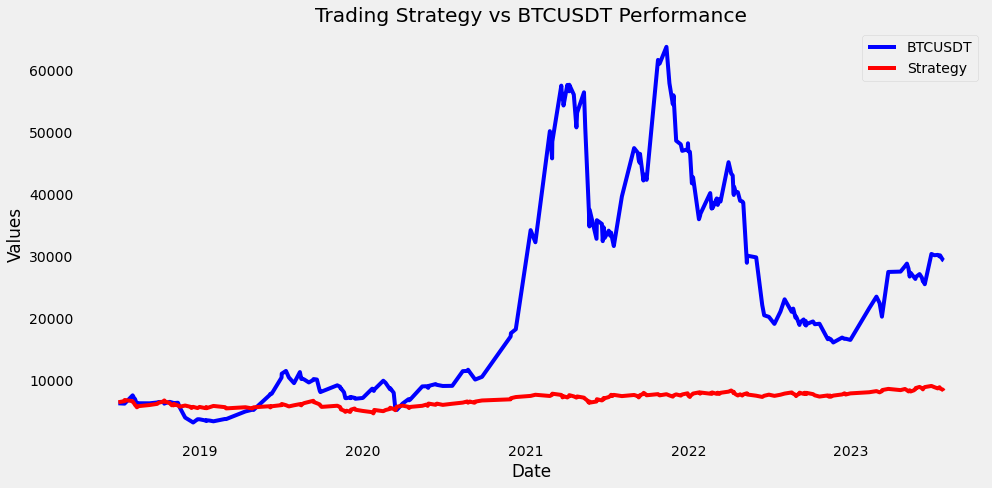

In [3]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


#Load the trade_info_df DataFrame
trade_info_df = pd.read_csv("trade_result_contra.csv")  # Replace with the actual filename

#Convert Entry time column to datetime format using the specific format
trade_info_df["Entry time"] = pd.to_datetime(trade_info_df["Entry time"])

#Sort the DataFrame based on Entry time
trade_info_df = trade_info_df.sort_values(by="Entry time")

#Calculate the profit for each trade
trade_info_df["Profit"] = np.where(trade_info_df["Trade Result"] == "Stop Loss Hit", -0.031, 0.029)

#Calculate cumulative profit changes
trade_info_df["Cumulative Profit"] = trade_info_df["Profit"].cumsum()

#Input your starting capital
starting_capital = dataset["Close"].iloc[0]# Replace with your starting capital

#Calculate the equity (capital + cumulative profit)
trade_info_df["Equity"] = starting_capital
for idx, row in trade_info_df.iterrows():
    trade_info_df.at[idx, "Equity"] += row["Cumulative Profit"] * trade_info_df.at[idx, "Equity"]


plt.figure(figsize=(14, 7))

plt.plot(trade_info_df["Entry time"], trade_info_df["Entry Price"], color='b', label="BTCUSDT")
plt.plot(trade_info_df["Entry time"], trade_info_df["Equity"], color='r', label="Strategy")

plt.xlabel("Date")
plt.ylabel("Values")
plt.title("Trading Strategy vs BTCUSDT Performance")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
#Calculating Percent Return for Trading Strategy
initial_capital = dataset["Close"].iloc[0]  #First value of btcusdt is taken as initial capital
final_equity = trade_info_df["Equity"].iloc[-1]  #The final equity value in the DataFrame
percent_return_strategy = ((final_equity - initial_capital) / initial_capital) * 100

#For BTCUSDT Buy and Hold
initial_BTCUSDT_price = trade_info_df["Entry Price"].iloc[0]  #Assuming the first entry price as initial BTCUSDT price
final_BTCUSDT_price = trade_info_df["Entry Price"].iloc[-1]  #Assuming the last entry price as final BTCUSDT price
percent_return_BTCUSDT = ((final_BTCUSDT_price - initial_BTCUSDT_price) / initial_BTCUSDT_price) * 100

print(f"Percent Return for Trading Strategy: {percent_return_strategy:.2f}%")
print(f"Percent Return for BTCUSDT Buy and Hold: {percent_return_BTCUSDT:.2f}%")


Percent Return for Trading Strategy: 31.70%
Percent Return for BTCUSDT Buy and Hold: 361.97%


In [5]:
#Function to calculate Drawdown
def calculate_drawdown(series):
    #Calculate the running maximum
    running_max = series.expanding(min_periods=1).max()
    #Calculate the drawdown series
    drawdown = series / running_max - 1
    return drawdown

#Function to calculate Max Drawdown
def calculate_max_drawdown(series):
    drawdown = calculate_drawdown(series)
    # Calculate the maximum drawdown
    max_drawdown = drawdown.min()
    return max_drawdown


Max Drawdown of Strategy: -31.37%
Max Drawdown of BTCUSDT: -74.67%


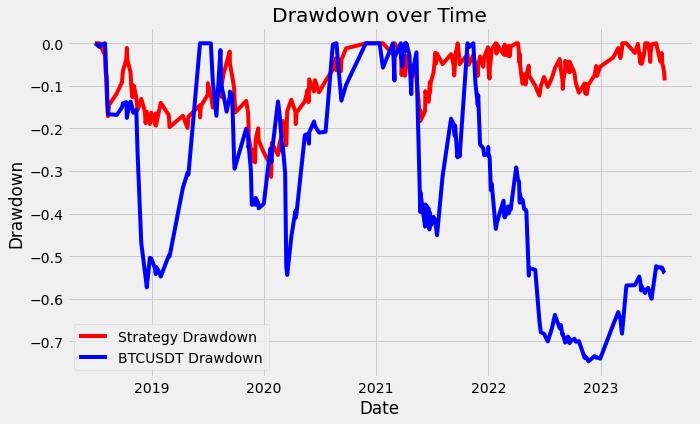

In [6]:
#Calculate drawdown for strategy and BTCUSDT
trade_info_df["Strategy_Drawdown"] = calculate_drawdown(trade_info_df["Equity"])
trade_info_df["BTCUSDT_Drawdown"] = calculate_drawdown(trade_info_df["Entry Price"])

#Calculate Max Drawdown for strategy and BTCUSDT
max_drawdown_strategy = calculate_max_drawdown(trade_info_df["Equity"])
max_drawdown_btc = calculate_max_drawdown(trade_info_df["Entry Price"])

print(f"Max Drawdown of Strategy: {max_drawdown_strategy * 100:.2f}%")
print(f"Max Drawdown of BTCUSDT: {max_drawdown_btc * 100:.2f}%")

#Plot the drawdown
plt.figure(figsize=(10, 6))
plt.plot(trade_info_df["Entry time"], trade_info_df["Strategy_Drawdown"], label="Strategy Drawdown", color='r')
plt.plot(trade_info_df["Entry time"], trade_info_df["BTCUSDT_Drawdown"], label="BTCUSDT Drawdown", color='b')
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.title("Drawdown over Time")
plt.grid(True)
plt.legend()
plt.show()
